In [1]:
# Instalujemy biblioteke aby połączyć sklearn i pytorch
!pip install skorch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Ładowaneie danych
df = pd.read_csv('./winequality-red.csv')

In [4]:
# Odzielamy target i funkcje
target = pd.DataFrame(df['quality'])
df.drop('quality', axis=1, inplace=True)

In [5]:
# Normalizacja cech
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(target)

In [6]:
# Sprawdzamy pierwsze wiersze
print(df.head())
print(target.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
   quali

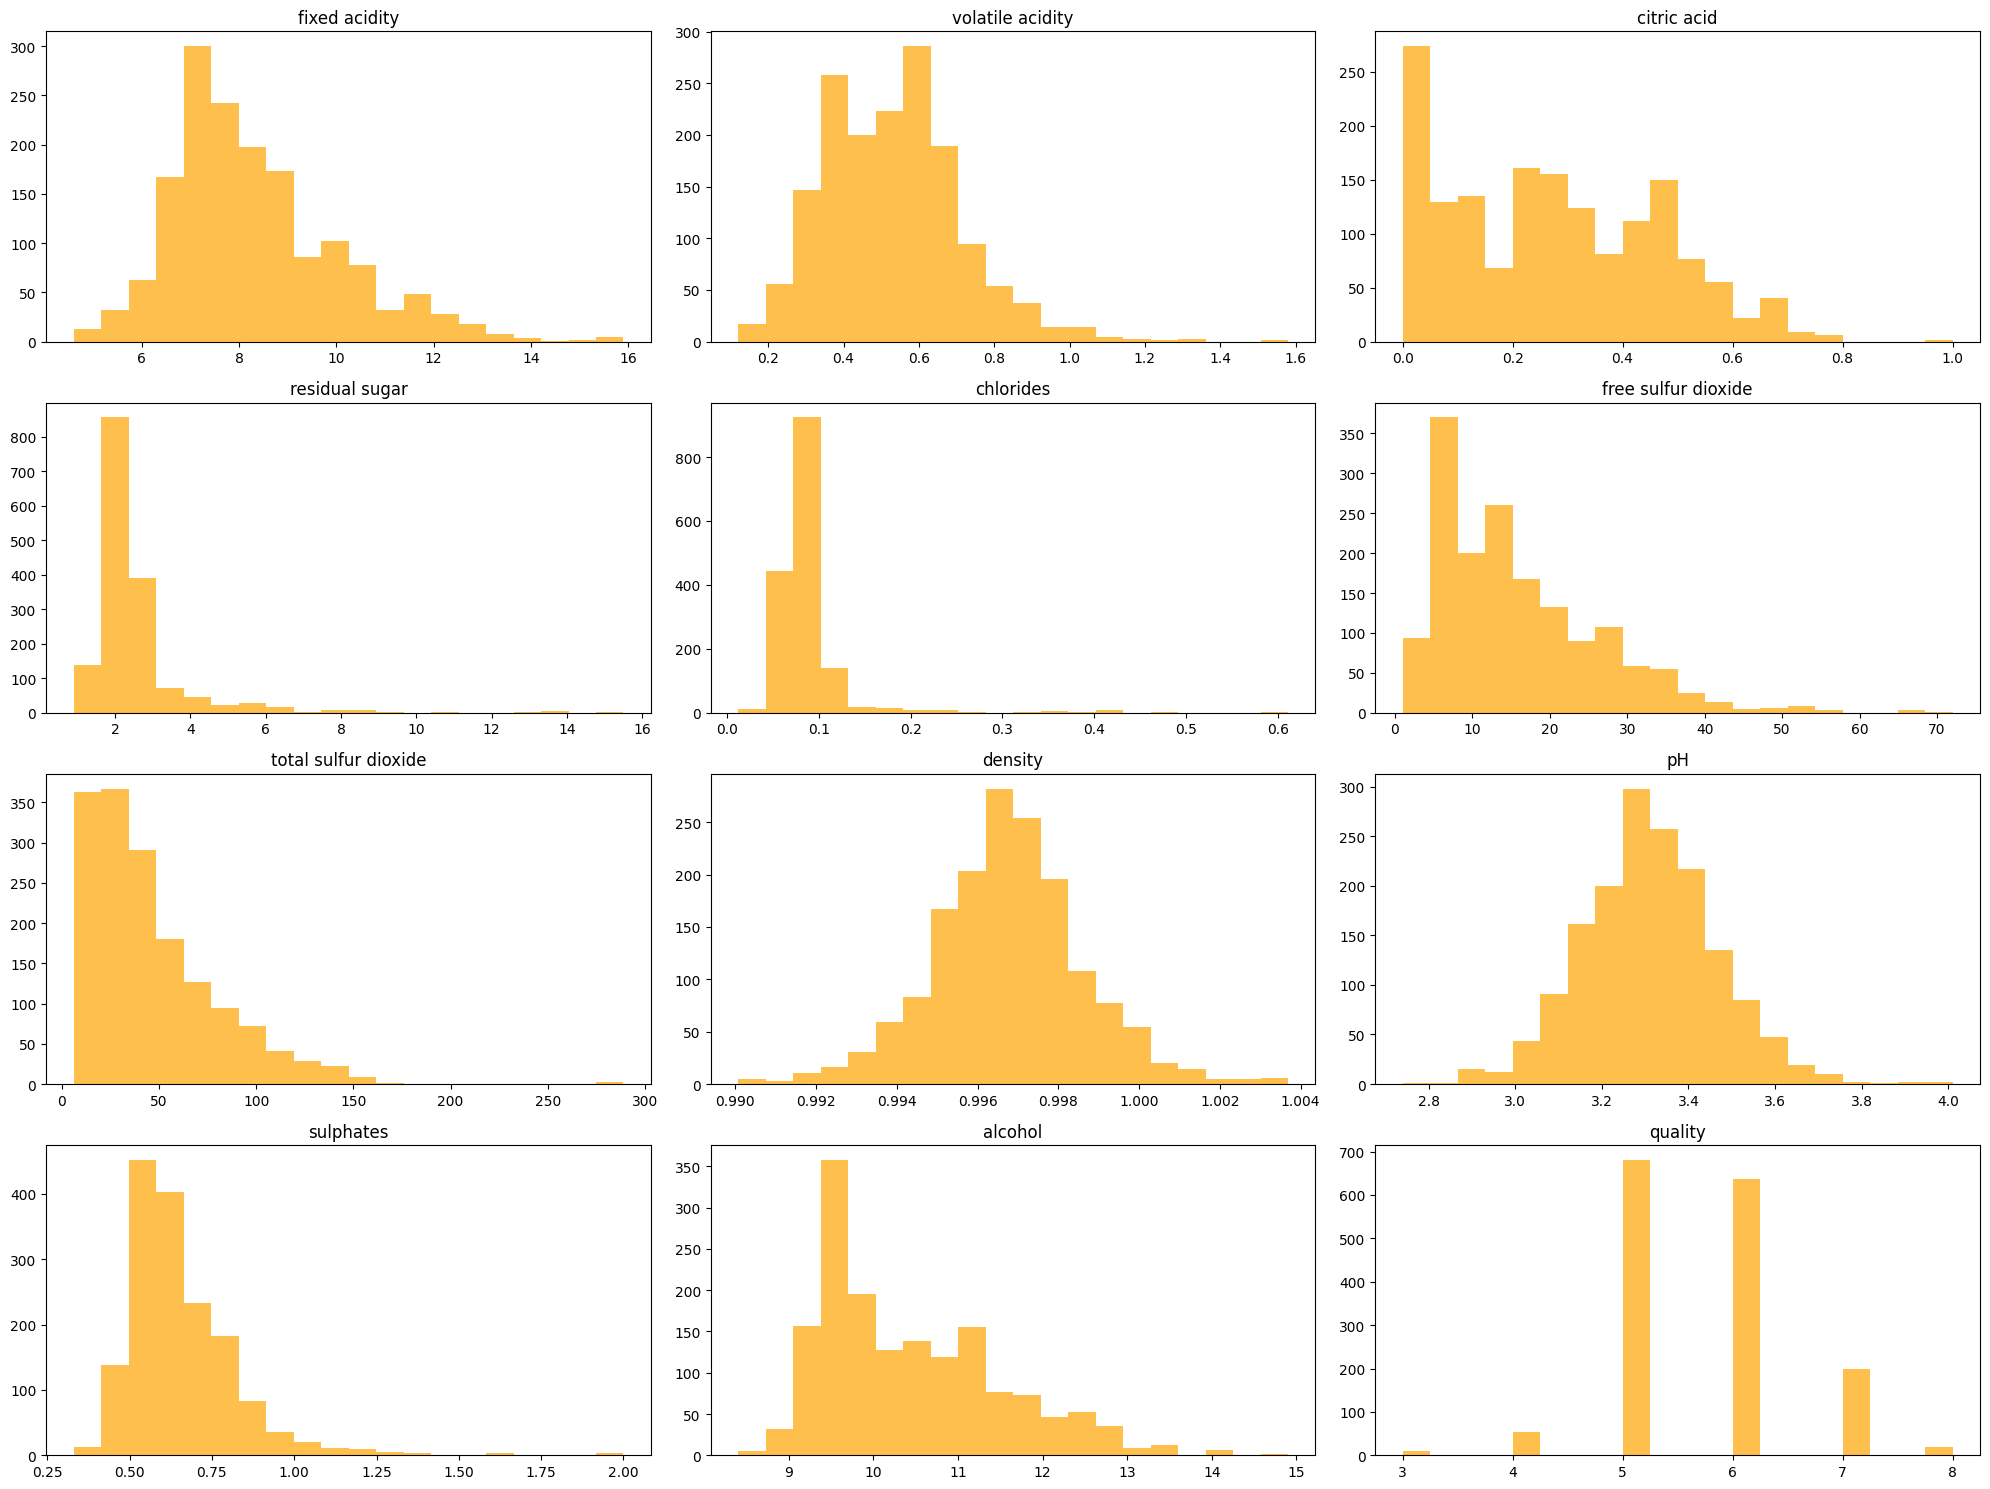

In [14]:
# Przygotowanie do hisotgramu
df_hist = df.copy()
df_hist['quality'] = target

# Tworzenie subplots - ustalanie liczby wierszy i kolumn na podstawie liczby kolumn w DataFrame
num_features = df_hist.shape[1]
nrows = (num_features + 2) // 3  # Zakładamy 3 kolumny na wiersz

fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(20, 15))
ax = ax.flatten()  # Spłaszczanie tablicy osi dla łatwiejszej iteracji

# Iteracja po wszystkich kolumnach i tworzenie histogramów
for i, col in enumerate(df_hist.columns):
    ax[i].hist(df_hist[col], bins=20, color='orange', alpha=0.7)
    ax[i].set(title=col)

# Usuwanie pustych subplotów
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])
plt.tight_layout()
plt.show()

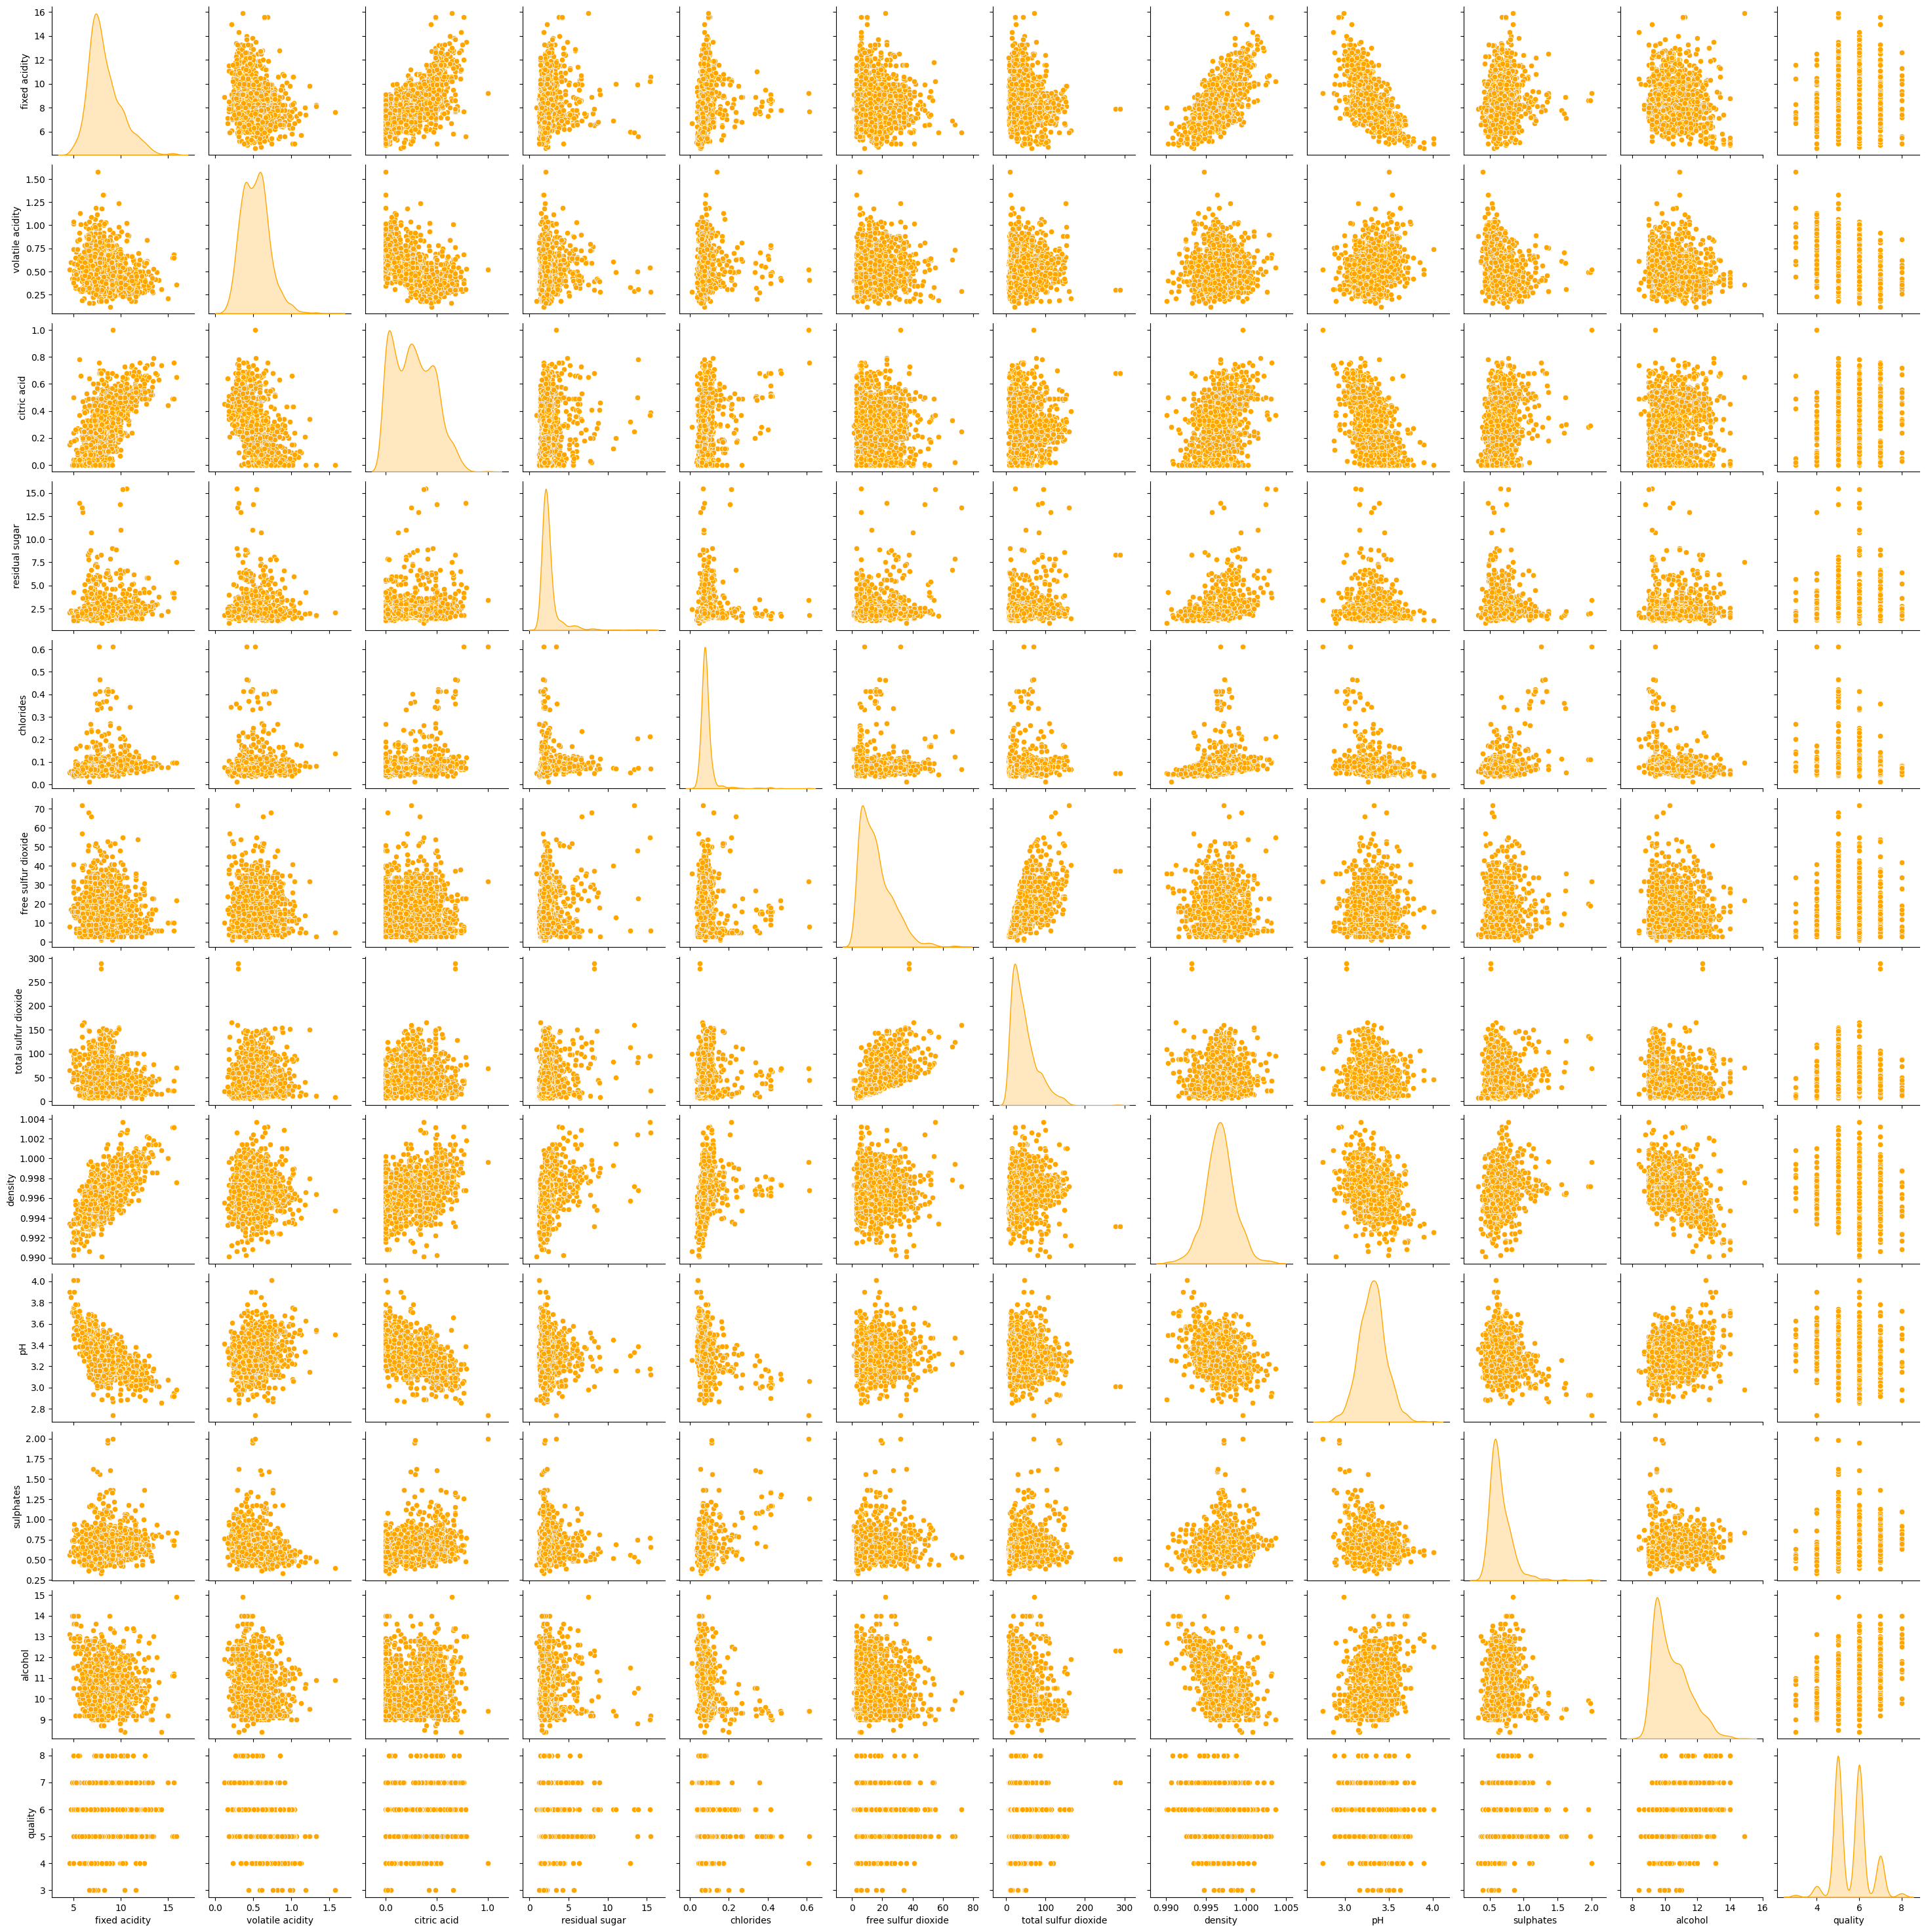

In [17]:
# Tworzymy macierz wykresu za pomocą Seaborn
sns.pairplot(df_hist, diag_kind='kde', plot_kws={'color': 'orange'}, diag_kws={'color': 'orange'})
plt.show()

In [18]:
# Dzieli dane na model testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(df.values, target.values, test_size=0.2, random_state=42)

In [19]:
# konwertujemy wartosc na kalse binarną
median_rent = target.median()[0]
y_train_class = (y_train >= median_rent).astype(int).ravel()
y_test_class = (y_test >= median_rent).astype(int).ravel()

In [20]:
# Definiujemy architekturę sieci neuronowej za pomocą elastycznych warstw
class WineQualityNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(WineQualityNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [21]:
# Definiujemy wymiary wejściowe i wyjściowe
input_dim = X_train.shape[1]
output_dim = 2


In [22]:
# Tworzymy siec neuronową
net = NeuralNetClassifier(
    module=WineQualityNN,
    max_epochs=20,
    lr=0.1,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    verbose=0,
    module__input_dim=input_dim,
    module__output_dim=output_dim
)

In [23]:
# Podajemy parametry dla GridSearcha
params = {
    'lr': [0.01,0.2,0.4],
    'max_epochs': [10,20,30],
    'module__hidden_dims': [
        [32],[64],[32,32]
    ],
    'optimizer__weight_decay': [0, 1e-4, 1e-2]
}


In [24]:
# Wykonujemy GridSearch
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy')
gs.fit(X_train.astype(np.float32), y_train_class)

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.WineQualityNN'>,
  module__input_dim=11,
  module__output_dim=2,
),
             param_grid={'lr': [0.01, 0.2, 0.4], 'max_epochs': [10, 20, 30],
                         'module__hidden_dims': [[32], [64], [32, 32]],
                         'optimizer__weight_decay': [0, 0.0001, 0.01]},
             scoring='accuracy')

In [25]:
# Sprawdzamy dla jakich parametróww mamy najlepsza walidacje krzyżową
print("Best parameters found: ", gs.best_params_)
print("Best cross-validation accuracy: ", gs.best_score_)

Best parameters found:  {'lr': 0.01, 'max_epochs': 30, 'module__hidden_dims': [32], 'optimizer__weight_decay': 0.0001}
Best cross-validation accuracy:  0.6880683005134633


In [26]:
# Sprawdzamy wszytskie rezultaty
results = pd.DataFrame(gs.cv_results_)
print(results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr  \
0        0.221782      0.112020         0.007332        0.000260     0.01   
1        0.137352      0.011106         0.007077        0.000123     0.01   
2        0.141883      0.007380         0.006516        0.001002     0.01   
3        0.130755      0.002633         0.007201        0.000129     0.01   
4        0.126894      0.007691         0.007004        0.000118     0.01   
..            ...           ...              ...             ...      ...   
76       0.412541      0.031357         0.005913        0.002116      0.4   
77       0.405074      0.015165         0.006763        0.000586      0.4   
78       0.435852      0.049431         0.007447        0.000214      0.4   
79       0.447901      0.013108         0.006253        0.001497      0.4   
80       0.446180      0.004398         0.007453        0.000084      0.4   

   param_max_epochs param_module__hidden_dims param_optimizer__weight_decay

In [27]:
# Wyszukujemy najlepszy model na zestawie testowym
best_model = gs.best_estimator_
test_accuracy = best_model.score(X_test.astype(np.float32), y_test_class)
print("Test set accuracy: ", test_accuracy)

Test set accuracy:  0.715625


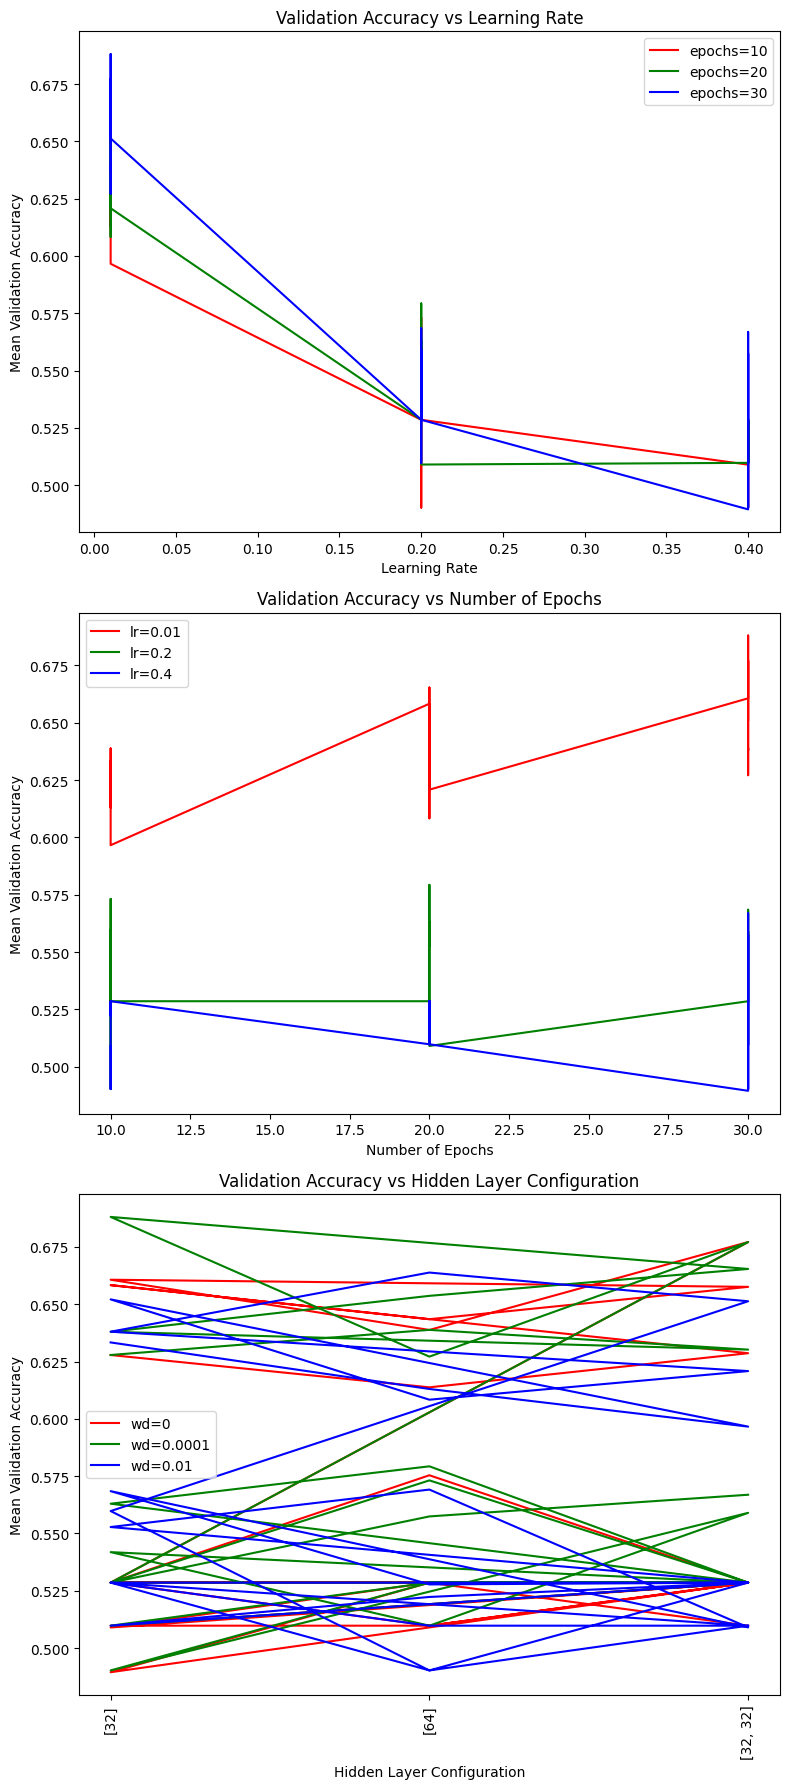

In [43]:
# Wykres i uwzgledneinie kolorów
colors = ['red', 'green', 'blue']

# Tworzenie figury i subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Wykres Validation Accuracy vs Learning Rate
axs[0].set_title('Validation Accuracy vs Learning Rate')
for i, max_epoch in enumerate(params['max_epochs']):
    subset = results[results['param_max_epochs'] == max_epoch]
    axs[0].plot(subset['param_lr'], subset['mean_test_score'], label=f'epochs={max_epoch}', color=colors[i])
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Mean Validation Accuracy')
axs[0].legend()

# Wykres Validation Accuracy vs Number of Epochs
axs[1].set_title('Validation Accuracy vs Number of Epochs')
for i, lr in enumerate(params['lr']):
    subset = results[results['param_lr'] == lr]
    axs[1].plot(subset['param_max_epochs'], subset['mean_test_score'], label=f'lr={lr}', color=colors[i])
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('Mean Validation Accuracy')
axs[1].legend()

# Wykres Validation Accuracy vs Hidden Layer Configuration
axs[2].set_title('Validation Accuracy vs Hidden Layer Configuration')
hidden_dims_str = [str(hd) for hd in params['module__hidden_dims']]
hidden_dims_mapping = {str(hd): i for i, hd in enumerate(params['module__hidden_dims'])}
results['hidden_dims_str'] = results['param_module__hidden_dims'].astype(str)
for i, weight_decay in enumerate(params['optimizer__weight_decay']):
    subset = results[results['param_optimizer__weight_decay'] == weight_decay]
    axs[2].plot([hidden_dims_mapping[hd] for hd in subset['hidden_dims_str']], subset['mean_test_score'], label=f'wd={weight_decay}', color=colors[i])
axs[2].set_xlabel('Hidden Layer Configuration')
axs[2].set_xticks(range(len(hidden_dims_str)))
axs[2].set_xticklabels(hidden_dims_str, rotation=90)
axs[2].set_ylabel('Mean Validation Accuracy')
axs[2].legend()

plt.tight_layout()
plt.show()

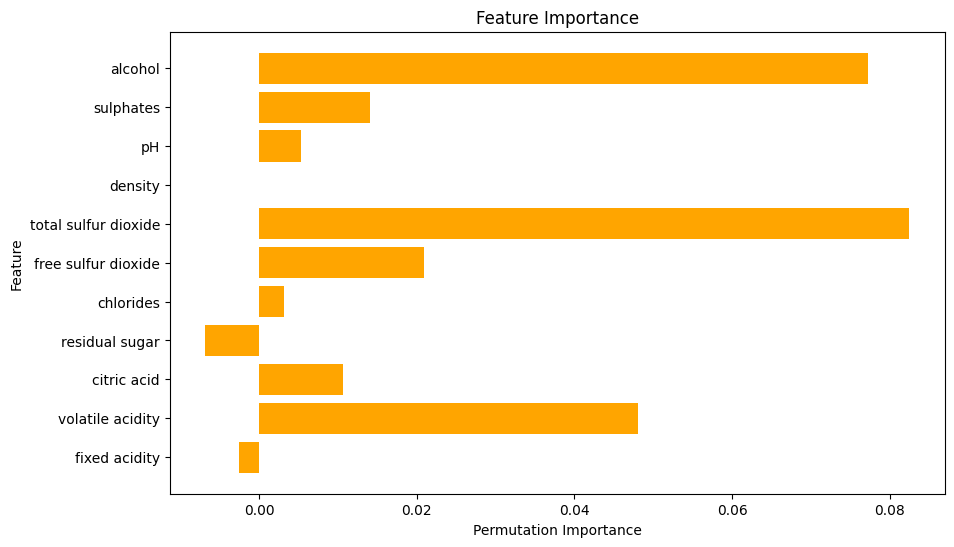

In [45]:
# Określamy ważność funkcji przy użyciu ważności permutacji
perm_importance = permutation_importance(best_model, X_test.astype(np.float32), y_test_class, n_repeats=10, random_state=42)
feature_importance = perm_importance.importances_mean
feature_names = df.columns

# Wyznaczenie cech fabuły
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center', color='orange')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

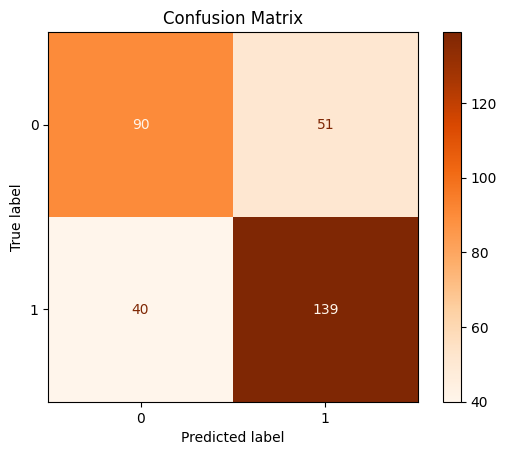

In [46]:
# Macierz pomyłek
y_pred = best_model.predict(X_test.astype(np.float32))
cm = confusion_matrix(y_test_class, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Krzywa ROC
y_proba = best_model.predict_proba(X_test.astype(np.float32))
fpr, tpr, _ = roc_curve(y_test_class, y_proba[:, 1])
roc_auc = auc(fpr, tpr)


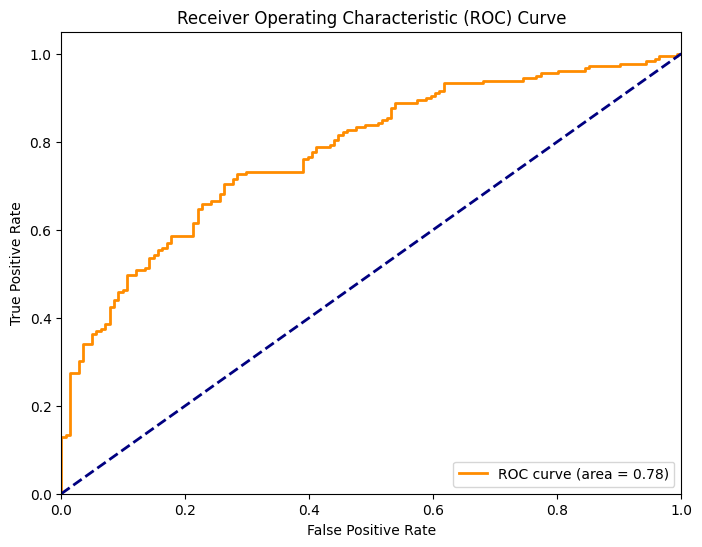

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [49]:
# Raport klasyfikacji
print(classification_report(y_test_class, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       141
           1       0.73      0.78      0.75       179

    accuracy                           0.72       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.72      0.71       320



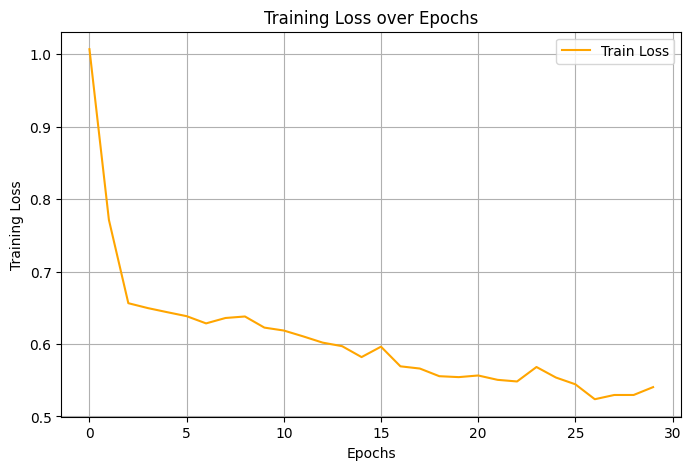

In [50]:
# Określamy straty w treningu na przestrzeni epok dla najlepszego modelu
plt.figure(figsize=(8, 5))
plt.plot(best_model.history[:, 'train_loss'], label='Train Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()